# Introduction #

This is an application of Decision Tree to correct wave forecasts. This jupyter notebook will alternate between commentary and excerpts from the paper. 



# Implementing the Decision Tree #



## The Dataset : As Time Series
In this implementation, the decision tree will predict hourly corrections on WW3 output. 

The input features are from WW3 output (Garcia et al, 2014) at Stonewall Banks buoy 46050 from winter or summer months between years 2012-2014, and the targets are the hourly corrections between the WW3 output and the observations made at that buoy for year 2015. 

>The elements of the hourly input feature vectors ($\mathbf{x}_i$) are modelled environmental parameters associated with the forecast for that hour, $i$. These include significant wave height, $Hs$, mean wave direction, $MWD$, mean period $T_m$, wind magnitude, $wndmag$, and wind direction $winddir$. The output target ($y_i$) for this study is the difference between the wave height observations, $H_{s,obs}$, and modelled wave height, $H_{s,WW3}$ for a particular hour, $i$:
    \begin{equation}
    y_i = H_{s,obs} - H_{s,WW3}
    \end{equation}
A negative (positive) target value indicate a wave height overestimation (underestimation).

In the code below, the data is imported and plotted as a time series, but note that these are not all subsequent output, since they come from concatenated seasons. The input features are an MxN array, where M = number of hours and N = number of features. The target, the hourly deviations between the WW3 output and the observations, is an M x 1 vector.

The retrieval of the data from the buoy and the data cleaning has already occurred.


The input features are an array of shape (10230, 5)


Text(0.5,0,'Time (hrs)')

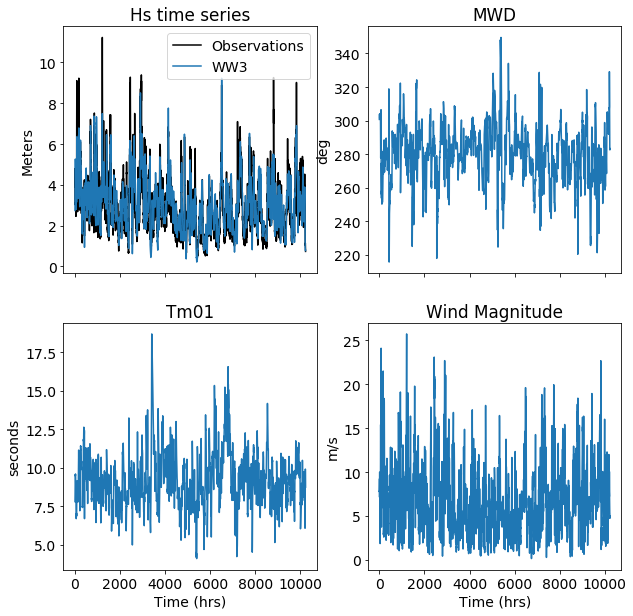

In [5]:
from sklearn import tree
import pickle
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.cm as cmx
from matplotlib import colors as colors
import scipy.io as sio
import matplotlib as mpl
import numpy as np


basic_cols=['#ff0000','k','#07076b']
my_cmap=colors.LinearSegmentedColormap.from_list('mycmap', basic_cols)

#Load the data. This data has already been cleaned - data gaps, either due to poor observations or gaps in wave forecasts
#have been removed. Choose either the winter dataset or the summer dataset. 
featmat = sio.loadmat('uncertaintyanalysis/winter_allfeatures_allyears.mat')

#The features are an array where the first three columns are hourly data points Hs, MWD, Tm output by WW3 at NDBC Buoy 46050 
#and the second two columns are wind magnitude and wind direction output by GFS and input into WW3. 

train_features = featmat['train_features'][:]
print("The input features are an array of shape " + str(train_features.shape)) #Note the shape MxN, where M = number of hours and N = number of features

#The train target are the hourly corrections (hourly deviations) between the WW3 output 
#and the observed wave height at NDBC Buoy 46050
train_target = featmat['train_target'][:]
train_target = train_target.squeeze()


#Visualize the time series before visualizing the feature space:
fig, ax = pl.subplots(2,2, sharex = True)
fig.set_size_inches(10,10)
ax[0,0].plot(train_obs, label = 'Observations', color = 'k')
ax[0,0].plot(train_features[:,0], label = 'WW3')
ax[0,0].set_title('Hs time series')
ax[0,0].legend()

ax[0,0].set_ylabel('Meters')

ax[0,1].plot(train_features[:,1])
ax[0,1].set_title('MWD')
ax[0,1].set_ylabel('deg')

ax[1,0].plot(train_features[:,2])
ax[1,0].set_ylabel('seconds')
ax[1,0].set_title('Tm01')
ax[1,0].set_xlabel('Time (hrs)')

ax[1,1].plot(train_features[:,3])
ax[1,1].set_ylabel('m/s')
ax[1,1].set_title('Wind Magnitude')
ax[1,1].set_xlabel('Time (hrs)')

## The Dataset: As Feature Space 

When the decision tree processes the data, it does not see the data as a continuous time series, but rather as a static feature space where the data are plotted against each other and with respect to the target value.

(0.0, 1.0, 0.0, 1.0)

/Users/ashleyellenson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


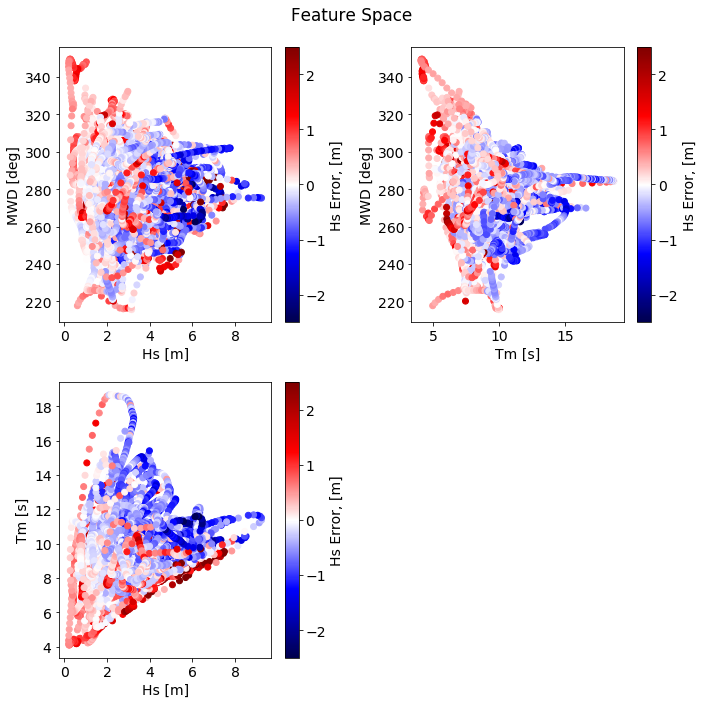

In [6]:

mpl.rcParams['font.size'] = 14

features = ['Hs [m]','MWD [deg]','Tm [s]']
fig,ax = pl.subplots(2,2, tight_layout = {'rect':[0,0,1,0.95]})
fig.suptitle('Feature Space')
fig.set_size_inches(3,3)
fig.set_size_inches(10,10)
for feat in range(3):
    if feat == 0:
        f1 = 0
        f2 = 1
        a1 = 0
        a2 = 0
    if feat == 1:
        f1 = 2 
        f2 = 1
        a1 = 0
        a2 = 1
    if feat == 2:
        f1 = 0 
        f2 = 2
        a1 = 1
        a2 = 0
    im = ax[a1,a2].scatter(train_features[:,f1], train_features[:,f2],c = train_target, cmap  = 'seismic', vmin = -2.5, vmax = 2.5)
    c = fig.colorbar(im, ax = ax[a1,a2])
    c.set_label('Hs Error, [m]')
    ax[a1,a2].set_xlabel(features[f1])
    ax[a1,a2].set_ylabel(features[f2])
ax[1,1].axis('off')


# Train and Implement a Bagged Regression Tree with Scikit Learn

Because the data is continuous, a regression tree as opposed to a decision tree (which is used for classification) will be used. This method also implements an ensemble technique called bagging.

In the module below, several key functions are called:

1. RandomForestRegressor : the base learner, or the regression tree itself
2. BaggingRegressor : the ensemble technique
3. GridSearchCV : the cross-validation routine to find the optimal decision tree parameters. 

Two bagged regression tree parameters are found through the grid search, depth and number of trees. 


Training now
Training time 1.0925812721252441
DT ensemble run took1.1364657878875732seconds featuring Hs_ww3 mwd_ww3 Tm_ww3
Training time 1.068105936050415
DT ensemble run took1.0894711017608643seconds featuring Hs_ww3 mwd_ww3 Tm_ww3
Total time difference is 2.2329702377319336


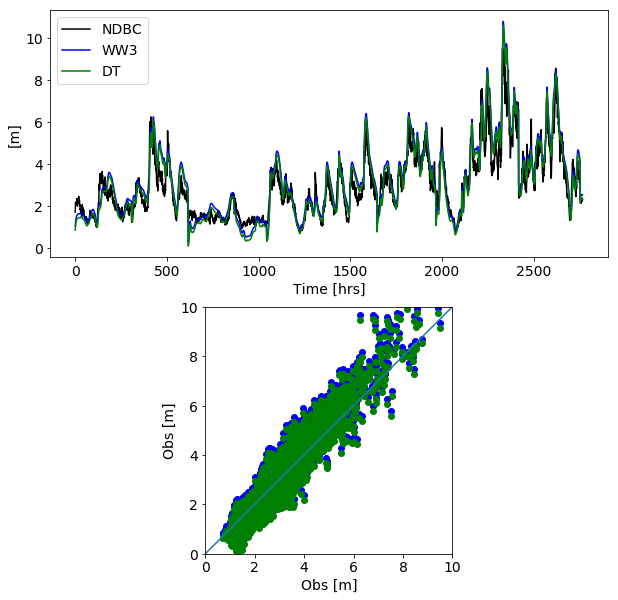

In [7]:
from sklearn.ensemble import BaggingRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import io
import os
import random
import sys
import time

#Things to change when you first log in:
start = time.time()
#Number of realizations. Because each time a regression tree forest is created is a random realization, many realizations are made
no_runs = 2
testbuoy = '46050'

#Even though we loaded the data earlier, the data is reloaded again here. 

all_data = sio.loadmat('uncertaintyanalysis/winter_allfeatures_allyears.mat')

#All the possible train feature names are Hs_ww3, mwd_ww3, Tm_ww3, wndmag, and wnddir
#Load the train features and choose which features you want as a list in the "train feature names"
trainfeaturenames = ['Hs_ww3','mwd_ww3','Tm_ww3']
train_features = all_data['train_features'][:]#Entire feature set, where the columns are Hs_ww3, MWD_ww3, Tm_ww3, windmag, winddir
train_target = all_data['train_target'][:]#Corrections (deviations from buoy readings)
train_target = train_target.squeeze()
train_features = train_features[:,0:len(trainfeaturenames)]

test_features = all_data['test_features'][:]
test_target = all_data['test_target'][:]
test_target = test_target.squeeze()

test_features = test_features[:,0:len(trainfeaturenames)]

ww3_hs_test = test_features[:,0]
obs_hs_test = ww3_hs_test + test_target


#Number of folds for the cross-fold validation
no_folds = 5

#Parameters to test
#depths = [5,10,15,20,30,50,70]
#treenos = [10,30,50,100,150,200,250,275,300,350,400,500]
depths = [2,5]
treenos = [5,10]
opt_params = {'base_estimator__max_depth':depths,'n_estimators':treenos}
RMSE_matrix = np.zeros((no_folds,len(depths),len(treenos)))

#Set up final data frames which will need to be saved

#Importance values for each feature
nandata = np.ones((no_runs,train_features.shape[1]))*np.nan
feature_importance_matrix = pd.DataFrame(nandata, columns = trainfeaturenames)

#Parameters for each run
nandata = np.ones((no_runs,2))*np.nan
forest_parameter_matrix = pd.DataFrame(nandata,columns = ['depth','number'])

#Training error
nandata = np.ones((no_runs,5))*np.nan
training_error_df = pd.DataFrame(nandata,columns = ['RMSE','bias','PE','SI','Corr_Coeff'])

#Test data
DT_var_matrix = np.ones((no_runs,len(ww3_hs_test)))*np.nan
print("Training now")

for runno in range(no_runs):
    t0_run = time.time()
    randinds = np.array(range(train_target.shape[0]))
    random.shuffle(randinds)
    
    DT_cv = GridSearchCV(BaggingRegressor(base_estimator = tree.DecisionTreeRegressor()), opt_params, cv = 5, scoring = 'neg_mean_absolute_error', iid = False)
    traintime = time.time()
    DT_cv.fit(train_features,train_target)
    traintime2 = time.time()
    train_t = traintime2 - traintime
    print("Training time " + str(train_t))
    
    
    DT_train_target = DT_cv.predict(train_features)

       
    #Save out forest parameters
    forest_parameter_matrix.iloc[runno]['depth'] = DT_cv.best_estimator_.base_estimator.max_depth
    forest_parameter_matrix.iloc[runno]['number'] = DT_cv.best_estimator_.n_estimators

    bestDT = DT_cv.best_estimator_
    #Record the importances
    importances = [x.feature_importances_ for x in bestDT.estimators_]
    importance_df = pd.DataFrame(importances, columns = trainfeaturenames)
    feature_importance_matrix.iloc[runno] = importance_df.describe().loc['mean'].values


    DT_corrections = DT_cv.predict(test_features)

    #make the ultimate prediction using decision tree corrections
    DT_var_matrix[runno,:] = DT_corrections
    t1_run = time.time()
    timedifference = t1_run - t0_run
    
    print("DT ensemble run took" + str(timedifference) + "seconds featuring " + " ".join(trainfeaturenames))
end = time.time()

totaltimediff = end-start
print("Total time difference is " + str(totaltimediff))

#Save the last tree
best_DT = DT_cv.best_estimator_
DT_pickle = open('./ExampleDT.pickle', 'wb')
pickle.dump(best_DT, DT_pickle)
DT_pickle.close()

meancorrections = np.mean(DT_var_matrix)
dt_hs = ww3_hs_test + meancorrections
#Visualize the results:

fig, ax = pl.subplots(2,1)
fig.set_size_inches(10,10)
ax[0].plot(obs_hs_test, color = 'k', label = 'NDBC')
ax[0].plot(ww3_hs_test, color = 'blue', label = 'WW3')
ax[0].plot(dt_hs, color = 'green', label = 'DT')
ax[0].legend()
ax[0].set_ylabel('[m]')
ax[0].set_xlabel('Time [hrs]')

ax[1].scatter(obs_hs_test, ww3_hs_test, color = 'blue')
ax[1].scatter(obs_hs_test, dt_hs, color = 'green')
ax[1].set_xlabel('Obs [m]')
ax[1].set_ylabel('Obs [m]')
ax[1].set_xlim((0,10))
ax[1].set_ylim((0,10))
ax[1].plot((0,10),(0,10))
ax[1].set_aspect('equal')



 # Decision Tree Logic #
 
  Now that a decision tree is trained, how did it work? 
  
## The Theory behind Decision Making ##
 
 ### Objective Function ### 

 
> The objective is to find the partitions wherein the mean target value of that partition \textcolor{black}{($\overline{y}(t)$)} is most similar to the rest of the target values encompassed within that partition. Specifically, the algorithm seeks the partitions, t, in the entire dataset, T, that minimize the sum of variances in $y_i$ across all the partitions: 
\begin{equation}
\frac{1}{N}\sum_{t\in{T}}\sum_{\mathbf{x}_i\in{t}}{(y_i - \overline{y}(t))^{2}}
\end{equation}
 These partitions are constructed by splitting the target values ${(y_i)}$ with respect to values of the input features ${(\mathbf{x}_i)}$. During the training phase, the regression tree establishes partitions.  See Figure \ref{figtreestruct} for an example of how the data is successively split on threshold values of input features, establishing a tree structure.} During the testing phase, the regression tree classifies an instance into \textcolor{black}{a partition} based on the values of the associated input features (${\mathbf{x}_i}$). The mean target value associated with that partition is then made the prediction for that instance. \textcolor{black}{See Figure \ref{figleaves} for an illustration of the final partitions, \mathbf{$t$}, made relative to the entire dataset $T$}.
  
  

## Decision Tree Structure ##

An example tree is depicted below. Splits are made at nodes, and final partitions are leaves and those are the values that are assigned to the test instance. 

>Representative tree structure of the splits made between the input features during training on the training data set. This decision tree has a depth of 5, meaning that five decisions are made to split the target values into 62 final partitions (not all pictured). The input features (mean wave period, $Tm01$, mean wave direction, $MWD$ and significant wave height, $Hs$) are indicated within each final tree node with a threshold value. Branches to the left (right) represent the division of data points less than (greater than) the threshold value. In the final partitions, MSE is the mean squared error between the member target values within the partition and the mean target value associated with that partition. The MSE is the value which the decision tree seeks to minimize overall the partitions in determining how to split the data space. $\overline{y}(t)$ is the mean target value associated with that partition.  During testing, $\overline{y}(t)$ is made the prediction for the instances which fall into that final partition. Instances fall into the partition because the value of the input features, $\mathbf{x_i}$, correspond with the thresholds determined during training. The same four final partitions shown here are also  illustrated within the feature space in Figure \ref{figleaves}}.

<img src = 'uncertaintyanalysis/DecisionTree_Example.png'>

>The number of splits made on a learning data set is referred to as the depth of a tree, and the number of trees used to make the final prediction in the bagged regression tree is the size. The size and depth of each bagged regression tree is determined during the training phase through cross validation, \textcolor{black}{as described by \cite{breiman1992submodel}, and in the following section.} Also, a tree might split on one feature more often than another, indicating that the feature is important in its decision making rules. 

     Hs_ww3   mwd_ww3    Tm_ww3
0  0.391389  0.098958  0.509652
1  0.393625  0.089062  0.517313


Text(0,0.5,'Feature Importance')

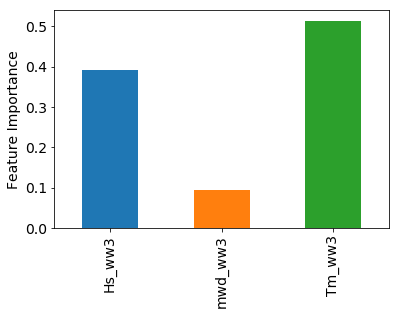

In [10]:
#For each run, the feature importances were saved in a feature importance matrix.
print(feature_importance_matrix)

fig, ax = pl.subplots(1,1)
feature_importance_matrix.mean().plot(kind = 'bar')
ax.set_ylabel('Feature Importance')

In [11]:
#For each run, the best depth/number of tree combination was saved in the forest parameter matrix. 

print(forest_parameter_matrix)

print("The best mean DT depth is " + str(forest_parameter_matrix['depth'].mean()))
print("The best mean number of DT is " + str(forest_parameter_matrix['number'].mean()))


   depth  number
0    5.0    10.0
1    5.0    10.0
The best mean DT depth is 5.0
The best mean number of DT is 10.0


## Decision Tree Established Partitions ##

In the next section, we'll visualize the partitions established during the training phase. 

(0.0, 1.0, 0.0, 1.0)

/Users/ashleyellenson/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


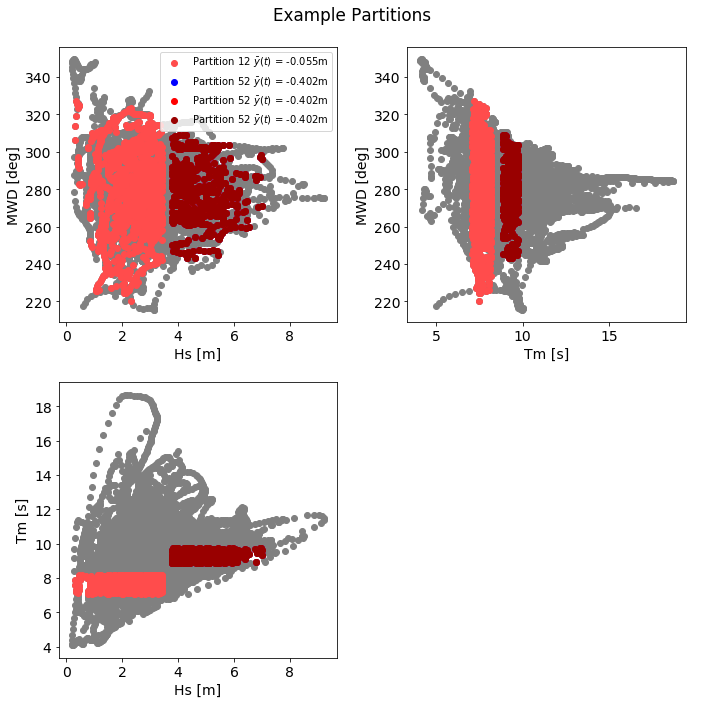

In [14]:
DT_p = open('./ExampleDT.pickle','rb')
DT_cv = pickle.load(DT_p)
DT_p.close()

estimator = DT_cv.estimators_[0]


bins = np.arange(0,65)
leaf_ids = estimator.apply(train_features) # find each final partition (or leaf) ID
hist_ids = np.argsort(np.histogram(leave_id,bins)[0]) #Find the most populated leaves by which examples share the same leaf ID number.
numexs, leafids = np.histogram(leave_id, bins)
leaf_ids = leaf_ids[hist_ids]
numexs = numexs[hist_ids]
topleaf_ids = leafids[-4:] #Choose the top 4 populated leaves to visualize
colors = ['#ff4c4c','#0000ff','#ff0000','#990000']
interested_vals = [np.float(np.round(estimator.tree_.value[ll][0][0],3)) for ll in leaf_ids]
#Pull interested leaves - the ones that you  are going to plot on the tree structure
#leaf_ids = [58, 59, 61, 62]

pl.rc('text', usetex=False)
fig,ax = pl.subplots(2,2, tight_layout =  {'rect':[0,0,1,0.95]})
fig.suptitle('Example Partitions')
fig.set_size_inches(10,10)
for feat in range(3):
    if feat == 0:
        f1 = 0
        f2 = 1
        a1 = 0
        a2 = 0
    if feat == 1:
        f1 = 2 
        f2 = 1
        a1 = 0
        a2 = 1
    if feat == 2:
        f1 = 0 
        f2 = 2
        a1 = 1
        a2 = 0
    ax[a1,a2].scatter(train_features[:,f1], train_features[:,f2],color = 'grey')
    ax[a1,a2].set_xlabel(features[f1])
    ax[a1,a2].set_ylabel(features[f2])


    for ii in range(4):
       
        leafidx = np.where(leave_id == leaf_ids[ii])[0]

        
        im = ax[a1,a2].scatter(train_features[leafidx,f1], train_features[leafidx,f2],color = colors[ii], label = 'Partition ' + str(leaf_ids[ii]) + r" $\bar{y}(t)$ = " + str(np.round(interested_vals[ii],3)) + 'm')
        if feat == 0:
            ax[a1,a2].legend(fontsize  = 10)
        #c = fig.colorbar(im, ax = ax[a1,a2])
ax[1,1].axis('off')

Text(0.5,0.98,'Most Populated Leaf Corrections')

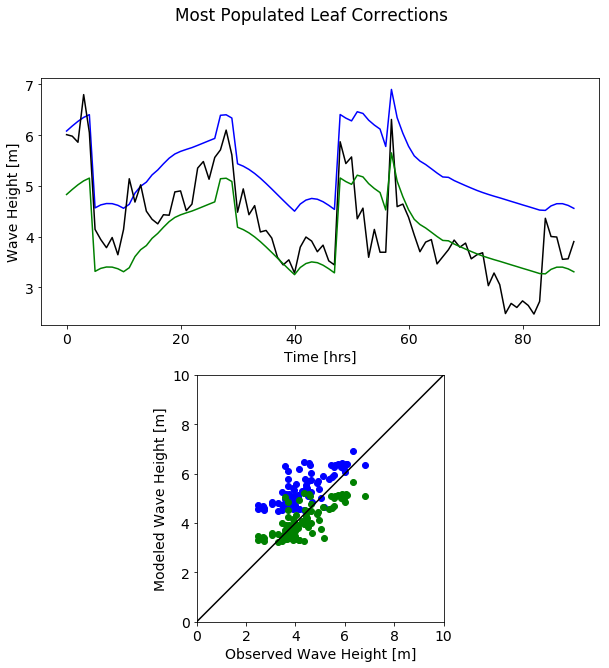

In [15]:
most_populated_leafID = topleaf_ids[0]
leaf_members = np.where(leave_id == most_populated_leafID)[0]
correction = estimator.tree_.value[most_populated_leafID][0][0] #What was the correction applied to these members
fig, ax = pl.subplots(2,1)
fig.set_size_inches((10,10))
ax[0].plot(train_features[leaf_members,0], color = 'blue')
ax[0].plot(train_obs[leaf_members], color = 'k')
ax[0].plot(train_features[leaf_members,0]+correction, color = 'green')
ax[0].set_xlabel('Time [hrs]')
ax[0].set_ylabel('Wave Height [m]')

ax[1].scatter(train_obs[leaf_members],train_features[leaf_members,0], color = 'blue')
ax[1].scatter(train_obs[leaf_members],train_features[leaf_members,0]+correction, color = 'green')
ax[1].set_xlim((0,10))
ax[1].set_ylim((0,10))
ax[1].plot((0,10),(0,10), color = 'k')
ax[1].set_xlabel('Observed Wave Height [m]')
ax[1].set_ylabel('Modeled Wave Height [m]')
ax[1].set_aspect('equal')
fig.suptitle('Most Populated Leaf Corrections')



In [25]:
#Note that the following code is from scikit learn documentation
#Which region of model phase space are these examples from? 

n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

node_indicator = estimator.decision_path(train_features)


sample_id = leaf_members[0] #Choose a sample from the leaf
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print(len(train_features))

print('Model Phase Space: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (train_features[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("%s %s %s)"
          % (trainfeaturenames[feature[node_id]],
             threshold_sign,
             threshold[node_id]))

10230
Model Phase Space: 
Tm_ww3 > 8.855159759521484)
Hs_ww3 > 3.7703919410705566)
Tm_ww3 > 9.746576309204102)
Hs_ww3 > 4.49979305267334)
mwd_ww3 <= 266.7436828613281)
